<a href="https://colab.research.google.com/github/tintenderete/TFM-Algoritmo-con-redes-evolutivas/blob/main/TFM_MODELOS_FIJOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATOS

In [ ]:

import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np



def get_h_price():

    symbols = [
    "ANA.MC", "ACX.MC", "ACS.MC", "AENA.MC", "AMS.MC", "MTS.MC", "SAB.MC", "BKIA.MC", "BKT.MC", "BBVA.MC", "CABK.MC",
    "CLNX.MC", "CIE.MC", "ENG.MC", "ELE.MC", "FER.MC", "GRF.MC", "IAG.MC", "IBE.MC", "ITX.MC", "IDR.MC", "COL.MC",
    "MEL.MC", "MRL.MC", "NTGY.MC", "PHM.MC", "REE.MC", "REP.MC", "SGRE.MC", "SLR.MC", "TRE.MC", "TEF.MC", "VIS.MC",
    "VWS.CO"
    ]


    # Descargar datos
    start_date = "2016-01-01"
    end_date = "2023-01-01"


    data = yf.download(symbols, start=start_date, end=end_date)


    adj_close = data['Adj Close']


    adj_close = adj_close.drop(["BKIA.MC", "REE.MC", "SGRE.MC"  ], axis = 1)


    adj_close = adj_close.fillna(method="ffill")

    return adj_close

In [ ]:
def calculate_sharpe_ratio(returns, risk_free_rate):
    """
    Calcular el ratio de Sharpe

    Parámetros:
    returns (np.array): Array de rendimientos de la inversión
    risk_free_rate (float): Tasa de rendimiento sin riesgo

    Devuelve:
    sharpe_ratio (float): Ratio de Sharpe
    """

    # Calcular el rendimiento promedio
    avg_returns = np.mean(returns)

    # Calcular la desviación estándar de los rendimientos
    std_returns = np.std(returns)

    # Calcular el ratio de Sharpe
    sharpe_ratio = (avg_returns - risk_free_rate) / std_returns

    return sharpe_ratio

In [ ]:
def h_price_to_data(h_price, days_backward = 150, days_forward = 30, days_steps = 1  ):
    datos_analisis = h_price
    X_DATA = []
    Y_DATA = []

    for i in range(days_backward, len(datos_analisis), days_steps):
        # retornos logaritmicos
        X_data = datos_analisis[i-days_backward:i]
        X_data = np.log(X_data).diff().dropna()
        X_DATA.append(X_data)

        # y
        data_forward = datos_analisis[i:i+days_forward]

        rs = calculate_sharpe_ratio(np.log(data_forward).diff().dropna(), 0)
        Y_data = np.argsort(np.argsort(rs))
        Y_DATA.append(Y_data)

    X_DATA = np.array(X_DATA)
    Y_DATA = np.array(Y_DATA)

    return X_DATA, Y_DATA

# X e Y

In [ ]:
ibex_data = get_h_price()

[*********************100%%**********************]  34 of 34 completed

ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['BKIA.MC', 'REE.MC', 'SGRE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [ ]:
X, Y = h_price_to_data(ibex_data)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

In [ ]:
r_min = np.min(Y, axis=1)[:, np.newaxis]
r_max = np.max(Y, axis=1)[:, np.newaxis]
r_min[-1], r_max[-1]

(array([0]), array([30]))

In [ ]:
Y_NORM = 2 * (Y - 0) / (30 - 0) - 1

# TRAIN AND VALID

In [ ]:
X.shape

(1647, 149, 31)

In [ ]:
X_TRAIN = X[:800]
Y_TRAIN = Y_NORM[:800]

X_VALID = X[800:1000]
Y_VALID = Y_NORM[800:1000]

X_TEST = X[1000:]
Y_TEST = Y_NORM[1000:]

# GUARDAR CARGAR MODELOS

In [ ]:
"""
# Guardar el modelo
model.save('my_model.h5')

# Cargar el modelo
from keras.models import load_model
loaded_model = load_model('my_model.h5')

"""

"\n# Guardar el modelo\nmodel.save('my_model.h5')\n\n# Cargar el modelo\nfrom keras.models import load_model\nloaded_model = load_model('my_model.h5')\n\n"

In [ ]:
import matplotlib.pyplot as plt

# ---- MODELOS  ----- > > >

In [ ]:
from keras import backend as K
import tensorflow as tf
hp_top = 10
hp_incremento_top = 2
def top_is_target_31(y_true, y_pred ):
  num_samples = K.shape(y_true)[0]

  w = K.arange(31, dtype='float32')
  w = K.reverse(w, axes=0) + 1

  w = tf.where(K.arange(31) < hp_top, w * hp_incremento_top, w)
  # Replicar w a lo largo del eje 0 (batch)
  #w = K.repeat_elements(K.expand_dims(w, 0), num_samples, axis=0)
  w = tf.tile(K.expand_dims(w, 0), [num_samples, 1])

  # Calcular la pérdida
  r = K.cast(y_true, 'float32')
  r_pred = K.cast(y_pred, 'float32')

  return K.sum(w * K.square(r - r_pred), axis=-1)

In [ ]:
import keras
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten
from keras import regularizers
from keras.models import Sequential

# 1

In [ ]:
inputs = keras.Input(shape=(X_TRAIN.shape[1:]))
m = inputs

mA = GRU(units=10)(m)


m = Flatten()(mA)

# Añadir capa Dense de salida
out = Dense(Y_TRAIN.shape[1], activation='tanh')(m)

model_GRU = keras.Model(inputs=inputs, outputs=out)

# Compilar el modelo
model_GRU.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',
        metrics=[])

model_GRU.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 149, 31)]         0         
                                                                 
 gru (GRU)                   (None, 10)                1290      
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 31)                341       
                                                                 
Total params: 1,631
Trainable params: 1,631
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h_gru = model_GRU.fit(X_TRAIN,Y_TRAIN,
          epochs=1000,
          batch_size=X_TRAIN.shape[0],
          validation_data = (X_VALID, Y_VALID),
          verbose = True
          )

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.3556 - val_loss: 0.3566
Epoch 2/1000
1/1 [==============================] - 0s 246ms/step - loss: 0.3522 - val_loss: 0.3581
Epoch 3/1000
1/1 [==============================] - 0s 245ms/step - loss: 0.3489 - val_loss: 0.3608
Epoch 4/1000
1/1 [==============================] - 0s 299ms/step - loss: 0.3458 - val_loss: 0.3644
Epoch 5/1000
1/1 [==============================] - 0s 458ms/step - loss: 0.3433 - val_loss: 0.3687
Epoch 6/1000
1/1 [==============================] - 1s 578ms/step - loss: 0.3415 - val_loss: 0.3716
Epoch 7/1000
1/1 [==============================] - 1s 509ms/step - loss: 0.3403 - val_loss: 0.3721
Epoch 8/1000
1/1 [==============================] - 1s 522ms/step - loss: 0.3395 - val_loss: 0.3704
Epoch 9/1000
1/1 [==============================] - 0s 369ms/step - loss: 0.3388 - val_loss: 0.3673
Epoch 10/1000
1/1 [==============================] - 0s 353ms/step - loss: 0.3382 - val_loss: 0.3638
Ep

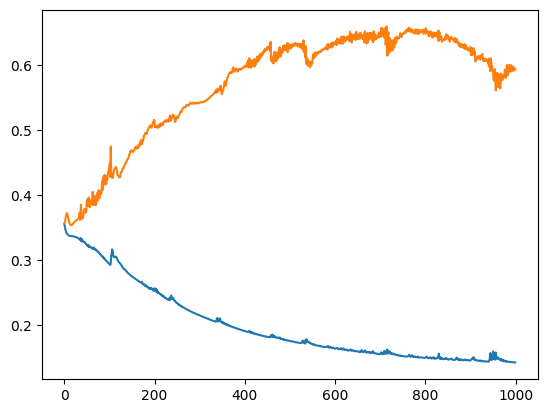

In [ ]:
plt.plot(h_gru.history["loss"])
plt.plot(h_gru.history["val_loss"])

# 2

In [ ]:
inputs = keras.Input(shape=(X_TRAIN.shape[1:]))
m = inputs

mA = GRU(units=10, kernel_regularizer=regularizers.l1_l2(l1=0.2, l2=0.2))(m)

#mA = Dropout(0.1)(mA)

#mA = Dense(units=1, activation = 'relu')(mA)

m = Flatten()(mA)

# Añadir capa Dense de salida
out = Dense(Y_TRAIN.shape[1], activation='tanh')(m)

model_GRU_2 = keras.Model(inputs=inputs, outputs=out)

# Compilar el modelo
model_GRU_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',
        metrics=[])

model_GRU_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 149, 31)]         0         
                                                                 
 gru_1 (GRU)                 (None, 10)                1290      
                                                                 
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 31)                341       
                                                                 
Total params: 1,631
Trainable params: 1,631
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h_gru_2 = model_GRU_2.fit(X_TRAIN,Y_TRAIN,
          epochs=1000,
          batch_size=X_TRAIN.shape[0],
          validation_data = (X_VALID, Y_VALID),
          verbose = True
          )

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 36.8758 - val_loss: 34.4894
Epoch 2/1000
1/1 [==============================] - 0s 163ms/step - loss: 34.4873 - val_loss: 32.2010
Epoch 3/1000
1/1 [==============================] - 0s 181ms/step - loss: 32.1961 - val_loss: 30.0022
Epoch 4/1000
1/1 [==============================] - 0s 179ms/step - loss: 29.9941 - val_loss: 27.8802
Epoch 5/1000
1/1 [==============================] - 0s 173ms/step - loss: 27.8684 - val_loss: 25.8513
Epoch 6/1000
1/1 [==============================] - 0s 170ms/step - loss: 25.8358 - val_loss: 23.9517
Epoch 7/1000
1/1 [==============================] - 0s 159ms/step - loss: 23.9327 - val_loss: 22.1470
Epoch 8/1000
1/1 [==============================] - 0s 176ms/step - loss: 22.1253 - val_loss: 20.4261
Epoch 9/1000
1/1 [==============================] - 0s 258ms/step - loss: 20.4025 - val_loss: 18.7966
Epoch 10/1000
1/1 [==============================] - 0s 299ms/step - loss: 18.7720 - 

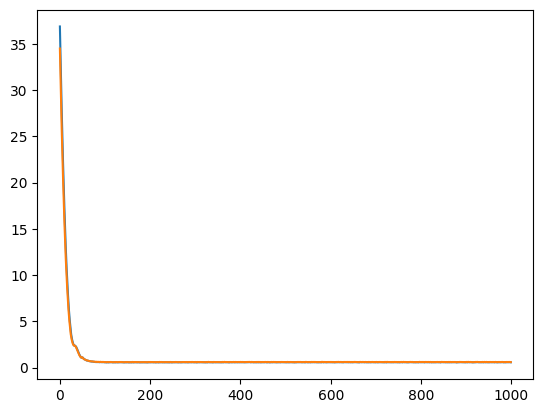

In [ ]:
plt.plot(h_gru_2.history["loss"])
plt.plot(h_gru_2.history["val_loss"])

# 3

In [ ]:
inputs = keras.Input(shape=(X_TRAIN.shape[1:]))
m = inputs

mA = GRU(units=10, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1))(m)

mA = Dropout(0.1)(mA)

#mA = Dense(units=1, activation = 'relu')(mA)

m = Flatten()(mA)

# Añadir capa Dense de salida
out = Dense(Y_TRAIN.shape[1], activation='tanh')(m)

model_GRU_3 = keras.Model(inputs=inputs, outputs=out)

# Compilar el modelo
model_GRU_3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',
        metrics=[])

model_GRU_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 149, 31)]         0         
                                                                 
 gru_2 (GRU)                 (None, 10)                1290      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 flatten_2 (Flatten)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 31)                341       
                                                                 
Total params: 1,631
Trainable params: 1,631
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h_gru_3 = model_GRU_3.fit(X_TRAIN,Y_TRAIN,
          epochs=1000,
          batch_size=X_TRAIN.shape[0],
          validation_data = (X_VALID, Y_VALID),
          verbose = True
          )

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 17.6632 - val_loss: 16.4929
Epoch 2/1000
1/1 [==============================] - 0s 148ms/step - loss: 16.4908 - val_loss: 15.3693
Epoch 3/1000
1/1 [==============================] - 0s 162ms/step - loss: 15.3644 - val_loss: 14.2906
Epoch 4/1000
1/1 [==============================] - 0s 156ms/step - loss: 14.2826 - val_loss: 13.2714
Epoch 5/1000
1/1 [==============================] - 0s 144ms/step - loss: 13.2608 - val_loss: 12.3077
Epoch 6/1000
1/1 [==============================] - 0s 160ms/step - loss: 12.2944 - val_loss: 11.3995
Epoch 7/1000
1/1 [==============================] - 0s 187ms/step - loss: 11.3846 - val_loss: 10.5384
Epoch 8/1000
1/1 [==============================] - 0s 158ms/step - loss: 10.5232 - val_loss: 9.7013
Epoch 9/1000
1/1 [==============================] - 0s 228ms/step - loss: 9.6855 - val_loss: 8.9108
Epoch 10/1000
1/1 [==============================] - 0s 299ms/step - loss: 8.8951 - val_

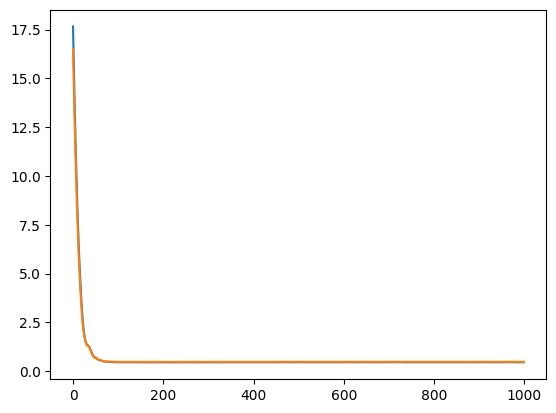

In [ ]:
plt.plot(h_gru_3.history["loss"])
plt.plot(h_gru_3.history["val_loss"])

# 4

In [ ]:
inputs = keras.Input(shape=(X_TRAIN.shape[1:]))
m = inputs

mA = GRU(units=100)(m)

m = Flatten()(mA)

# Añadir capa Dense de salida
out = Dense(Y_TRAIN.shape[1], activation='tanh')(m)

model_GRU_4 = keras.Model(inputs=inputs, outputs=out)

# Compilar el modelo
model_GRU_4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',
        metrics=[])

model_GRU_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 149, 31)]         0         
                                                                 
 gru_3 (GRU)                 (None, 100)               39900     
                                                                 
 flatten_3 (Flatten)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 31)                3131      
                                                                 
Total params: 43,031
Trainable params: 43,031
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_TRAIN.shape

(800, 149, 31)

In [ ]:
h_gru_4 = model_GRU_4.fit(X_TRAIN,Y_TRAIN,
          epochs=1000,
          batch_size=X_TRAIN.shape[0],
          validation_data = (X_VALID, Y_VALID),
          verbose = True
          )

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.3555 - val_loss: 0.3544
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3463 - val_loss: 0.3618
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3380 - val_loss: 0.3755
Epoch 4/1000
1/1 [==============================] - 2s 2s/step - loss: 0.3422 - val_loss: 0.3565
Epoch 5/1000
1/1 [==============================] - 2s 2s/step - loss: 0.3366 - val_loss: 0.3540
Epoch 6/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3367 - val_loss: 0.3559
Epoch 7/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3365 - val_loss: 0.3597
Epoch 8/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3358 - val_loss: 0.3642
Epoch 9/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3348 - val_loss: 0.3684
Epoch 10/1000
1/1 [==============================] - 1s 1s/step - loss: 0.3338 - val_loss: 0.3719
Epoch 11/1000
1/1 [==========

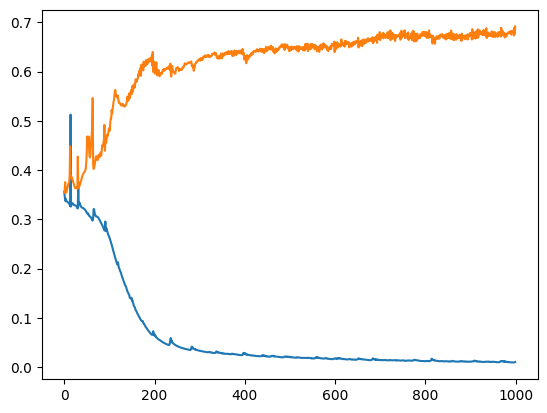

In [ ]:
plt.plot(h_gru_4.history["loss"])
plt.plot(h_gru_4.history["val_loss"])

# 5

In [ ]:
inputs = keras.Input(shape=(X_TRAIN.shape[1:]))
m = inputs

mA = GRU(units=50)(m)
mA = Dense(50)(mA)
m = Flatten()(mA)

# Añadir capa Dense de salida
out = Dense(Y_TRAIN.shape[1], activation='tanh')(m)

model_GRU_5 = keras.Model(inputs=inputs, outputs=out)

# Compilar el modelo
model_GRU_5.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',
        metrics=[])

model_GRU_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 149, 31)]         0         
                                                                 
 gru_4 (GRU)                 (None, 50)                12450     
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 flatten_4 (Flatten)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 31)                1581      
                                                                 
Total params: 16,581
Trainable params: 16,581
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h_gru_5 = model_GRU_5.fit(X_TRAIN,Y_TRAIN,
          epochs=1000,
          batch_size=X_TRAIN.shape[0],
          validation_data = (X_VALID, Y_VALID),
          verbose = True
          )

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.3556 - val_loss: 0.3592
Epoch 2/1000
1/1 [==============================] - 1s 659ms/step - loss: 0.3477 - val_loss: 0.3688
Epoch 3/1000
1/1 [==============================] - 1s 598ms/step - loss: 0.3410 - val_loss: 0.3742
Epoch 4/1000
1/1 [==============================] - 1s 526ms/step - loss: 0.3393 - val_loss: 0.3645
Epoch 5/1000
1/1 [==============================] - 1s 523ms/step - loss: 0.3375 - val_loss: 0.3602
Epoch 6/1000
1/1 [==============================] - 1s 525ms/step - loss: 0.3362 - val_loss: 0.3610
Epoch 7/1000
1/1 [==============================] - 1s 521ms/step - loss: 0.3357 - val_loss: 0.3635
Epoch 8/1000
1/1 [==============================] - 1s 510ms/step - loss: 0.3355 - val_loss: 0.3662
Epoch 9/1000
1/1 [==============================] - 1s 606ms/step - loss: 0.3350 - val_loss: 0.3698
Epoch 10/1000
1/1 [==============================] - 1s 515ms/step - loss: 0.3340 - val_loss: 0.3747
Ep

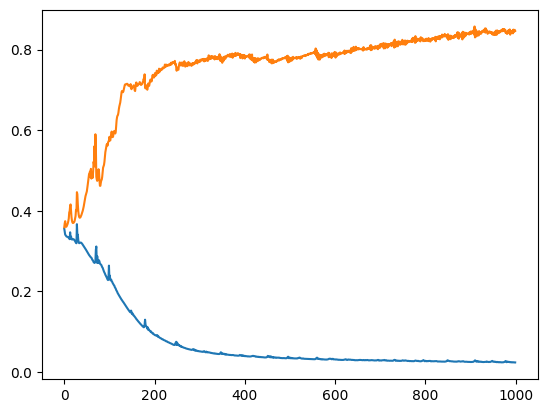

In [ ]:
plt.plot(h_gru_5.history["loss"])
plt.plot(h_gru_5.history["val_loss"])

# 6

In [ ]:
inputs = keras.Input(shape=(X_TRAIN.shape[1:]))
m = inputs
# , kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1)
mA = GRU(units=25)(m)
mA = Dropout(0.5)(mA)
mA = Dense(25)(mA)
mA = Dropout(0.5)(mA)
m = Flatten()(mA)

# Añadir capa Dense de salida
out = Dense(Y_TRAIN.shape[1], activation='tanh')(m)

model_GRU_6 = keras.Model(inputs=inputs, outputs=out)

# Compilar el modelo
model_GRU_6.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',
        metrics=[])

model_GRU_6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 149, 31)]         0         
                                                                 
 gru_5 (GRU)                 (None, 25)                4350      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_6 (Dense)             (None, 25)                650       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 flatten_5 (Flatten)         (None, 25)                0         
                                                                 
 dense_7 (Dense)             (None, 31)                806 

In [ ]:
h_gru_6 = model_GRU_6.fit(X_TRAIN,Y_TRAIN,
          epochs=1000,
          batch_size=X_TRAIN.shape[0],
          validation_data = (X_VALID, Y_VALID),
          verbose = True
          )

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.3559 - val_loss: 0.3525
Epoch 2/1000
1/1 [==============================] - 0s 273ms/step - loss: 0.3507 - val_loss: 0.3510
Epoch 3/1000
1/1 [==============================] - 0s 267ms/step - loss: 0.3468 - val_loss: 0.3522
Epoch 4/1000
1/1 [==============================] - 0s 286ms/step - loss: 0.3434 - val_loss: 0.3544
Epoch 5/1000
1/1 [==============================] - 0s 279ms/step - loss: 0.3431 - val_loss: 0.3559
Epoch 6/1000
1/1 [==============================] - 0s 288ms/step - loss: 0.3416 - val_loss: 0.3571
Epoch 7/1000
1/1 [==============================] - 0s 300ms/step - loss: 0.3399 - val_loss: 0.3578
Epoch 8/1000
1/1 [==============================] - 0s 272ms/step - loss: 0.3393 - val_loss: 0.3585
Epoch 9/1000
1/1 [==============================] - 0s 267ms/step - loss: 0.3389 - val_loss: 0.3592
Epoch 10/1000
1/1 [==============================] - 0s 275ms/step - loss: 0.3390 - val_loss: 0.3599
Ep

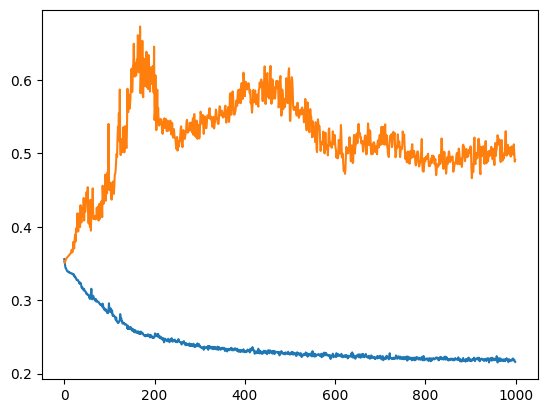

In [ ]:
plt.plot(h_gru_6.history["loss"])
plt.plot(h_gru_6.history["val_loss"])

# 7

In [ ]:
inputs = keras.Input(shape=(X_TRAIN.shape[1:]))
m = inputs

mA = GRU(units=1, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1))(m)

mA = Dropout(0.1)(mA)

mA = Dense(units=1, activation = 'relu')(mA)

m = Flatten()(mA)

# Añadir capa Dense de salida
out = Dense(Y_TRAIN.shape[1], activation='tanh')(m)

model_GRU_7 = keras.Model(inputs=inputs, outputs=out)

# Compilar el modelo
model_GRU_7.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',
          metrics=[])

model_GRU_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 149, 31)]         0         
                                                                 
 gru_6 (GRU)                 (None, 1)                 102       
                                                                 
 dropout_3 (Dropout)         (None, 1)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
 flatten_6 (Flatten)         (None, 1)                 0         
                                                                 
 dense_9 (Dense)             (None, 31)                62        
                                                                 
Total params: 166
Trainable params: 166
Non-trainable param

In [ ]:
h_gru_7 = model_GRU_7.fit(X_TRAIN,Y_TRAIN,
          epochs=1000,
          batch_size=X_TRAIN.shape[0],
          validation_data = (X_VALID, Y_VALID),
          verbose = True
          )

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 2.5853 - val_loss: 2.4583
Epoch 2/1000
1/1 [==============================] - 0s 128ms/step - loss: 2.4563 - val_loss: 2.3384
Epoch 3/1000
1/1 [==============================] - 0s 131ms/step - loss: 2.3342 - val_loss: 2.2304
Epoch 4/1000
1/1 [==============================] - 0s 154ms/step - loss: 2.2239 - val_loss: 2.1283
Epoch 5/1000
1/1 [==============================] - 0s 118ms/step - loss: 2.1195 - val_loss: 2.0256
Epoch 6/1000
1/1 [==============================] - 0s 124ms/step - loss: 2.0147 - val_loss: 1.9261
Epoch 7/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.9134 - val_loss: 1.8314
Epoch 8/1000
1/1 [==============================] - 0s 121ms/step - loss: 1.8171 - val_loss: 1.7357
Epoch 9/1000
1/1 [==============================] - 0s 104ms/step - loss: 1.7199 - val_loss: 1.6466
Epoch 10/1000
1/1 [==============================] - 0s 101ms/step - loss: 1.6293 - val_loss: 1.5625
Ep

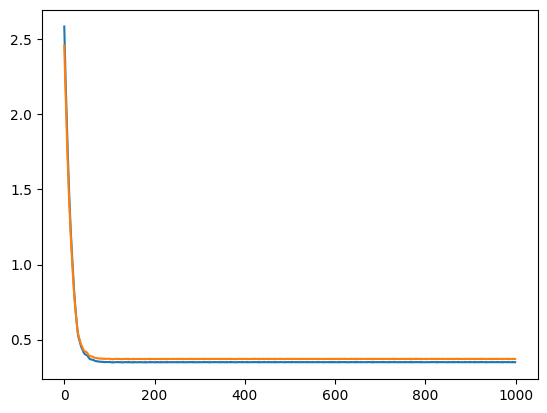

In [ ]:
plt.plot(h_gru_7.history["loss"])
plt.plot(h_gru_7.history["val_loss"])

# NUEVOS INPUTS PARA USAR DENSA

#DATOS

In [ ]:
import numpy as np

In [ ]:
import yfinance as yf
import pandas as pd

def descargar_datos_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data["Adj Close"]

# Ticker del IBEX 35 en Yahoo Finance
ticker = "^IBEX"

# Fechas de inicio y fin
start_date = "2016-01-01"
end_date = "2023-01-01"

# Descarga de datos
bench = descargar_datos_yahoo(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
bench.isna().sum()

0

In [ ]:
bench.name = "Bench"

In [ ]:
bench

Date
2016-01-04    9313.190430
2016-01-05    9335.190430
2016-01-06    9197.390625
2016-01-07    9059.291016
2016-01-08    8909.191406
                 ...     
2022-12-23    8269.099609
2022-12-27    8270.099609
2022-12-28    8258.500000
2022-12-29    8318.299805
2022-12-30    8229.099609
Name: Bench, Length: 1791, dtype: float64

In [ ]:
start_date = "2016-01-01"
end_date = "2023-01-01"

tickers = ['BKT', 'IBE', 'REP', 'TEF', 'ACS', 'FER', 'IDR', 'BBVA', 'ITX', 'SAN',
       'ENG', 'SAB', 'MAP', 'GRF', 'MTS', 'AMS', 'IAG', 'CABK', 'SCYR', 'ELE',
       'ACX', 'AENA', 'ANA', 'MRL', 'CLNX', 'MEL', 'COL', 'NTGY', 'SLR', 'FDR',
       'ROVI', 'RED', 'ANE', 'LOG', 'UNI']

tickers = [ticker + ".MC" for ticker in tickers]
#tickers

In [ ]:
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%%**********************]  35 of 35 completed


In [ ]:
data["Adj Close"].isna().sum()

ACS.MC        0
ACX.MC        0
AENA.MC       0
AMS.MC        0
ANA.MC        0
ANE.MC     1406
BBVA.MC       0
BKT.MC        0
CABK.MC       0
CLNX.MC       0
COL.MC        0
ELE.MC        0
ENG.MC        0
FDR.MC        0
FER.MC        0
GRF.MC        0
IAG.MC        0
IBE.MC        0
IDR.MC        0
ITX.MC        0
LOG.MC        0
MAP.MC        0
MEL.MC        0
MRL.MC        0
MTS.MC        0
NTGY.MC       0
RED.MC        0
REP.MC        0
ROVI.MC       0
SAB.MC        0
SAN.MC        0
SCYR.MC       0
SLR.MC        0
TEF.MC        0
UNI.MC      383
dtype: int64

In [ ]:
data = data["Adj Close"]

In [ ]:
data.drop(["ANE.MC"],axis = 1, inplace=True)

In [ ]:
data.isna().sum().sum()

383

In [ ]:
data = data.fillna(method="ffill")
data = data.fillna(method="bfill")

In [ ]:
data.isna().sum().sum()

0

In [ ]:
ibex_data = data

In [ ]:
ibex_data

,ACS.MC,ACX.MC,AENA.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CLNX.MC,COL.MC,...,NTGY.MC,RED.MC,REP.MC,ROVI.MC,SAB.MC,SAN.MC,SCYR.MC,SLR.MC,TEF.MC,UNI.MC
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,15.980104,5.751740,79.277679,36.199356,60.231125,4.407446,4.751968,2.298497,14.772966,5.183412,...,10.938681,11.855685,6.404625,12.837639,1.201982,3.033155,1.313086,0.700000,5.248940,1.019846
2016-01-05,16.011051,5.890941,79.734390,36.367851,60.508472,4.436829,4.754172,2.279122,14.747093,5.223532,...,11.072264,11.923389,6.347962,12.837639,1.198304,3.007060,1.333093,0.745000,5.275911,1.019846
2016-01-06,15.887266,5.630723,79.315742,36.458935,60.346691,4.342002,4.649078,2.198032,14.574611,5.055030,...,10.989146,11.899774,6.166520,12.846617,1.186534,2.910236,1.284186,0.720000,5.237833,1.019846
2016-01-07,15.447847,5.364235,77.907539,35.552696,58.127884,4.286575,4.581467,2.142059,14.600484,4.894553,...,10.891187,11.828919,5.922048,12.765821,1.158581,2.850492,1.210084,0.700000,5.197640,1.019846
2016-01-08,15.206474,5.406247,78.630669,35.038105,58.089371,4.189745,4.524878,2.115508,14.238276,4.886529,...,10.768416,11.776964,5.684580,13.017186,1.120330,2.773582,1.202674,0.700000,5.072830,1.019846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,25.243809,8.771631,116.368965,48.669140,167.100845,5.398695,6.106119,3.428859,31.025721,5.710853,...,24.128513,15.721425,14.106544,35.113213,0.873044,2.744514,2.508429,17.295000,3.251023,0.995289
2022-12-27,25.262548,8.845105,116.175179,48.204399,167.780121,5.382497,6.063608,3.412019,30.815815,5.706074,...,24.012835,15.542825,14.325471,35.113213,0.872469,2.764152,2.517959,17.150000,3.243335,0.994336
2022-12-28,25.187584,8.775399,115.254692,48.708691,167.391968,5.388214,6.075202,3.417632,30.955750,5.749085,...,23.897158,15.524024,14.230286,34.570324,0.869726,2.747459,2.498898,17.000000,3.255828,1.011496


In [ ]:
import matplotlib.pyplot as plt

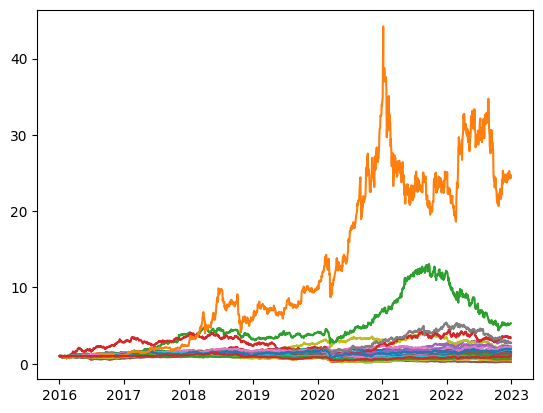

In [ ]:
plt.plot(ibex_data / ibex_data.iloc[0,:]);

In [ ]:
ibex_data.isna().sum().sum(), bench.isna().sum()

(0, 0)

In [ ]:
ibex_data["Bench"] = bench

In [ ]:
ibex_data.isna().sum().sum()

2

In [ ]:
ibex_data.fillna(method='ffill', inplace=True)  # forward fill

In [ ]:
ibex_data.isna().sum().sum()

0

In [ ]:
ibex_data.Bench

Date
2016-01-04    9313.190430
2016-01-05    9335.190430
2016-01-06    9197.390625
2016-01-07    9059.291016
2016-01-08    8909.191406
                 ...     
2022-12-23    8269.099609
2022-12-27    8270.099609
2022-12-28    8258.500000
2022-12-29    8318.299805
2022-12-30    8229.099609
Name: Bench, Length: 1792, dtype: float64

In [ ]:
ibex_data

,ACS.MC,ACX.MC,AENA.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CLNX.MC,COL.MC,...,RED.MC,REP.MC,ROVI.MC,SAB.MC,SAN.MC,SCYR.MC,SLR.MC,TEF.MC,UNI.MC,Bench
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,15.980104,5.751740,79.277679,36.199356,60.231125,4.407446,4.751968,2.298497,14.772966,5.183412,...,11.855685,6.404625,12.837639,1.201982,3.033155,1.313086,0.700000,5.248940,1.019846,9313.190430
2016-01-05,16.011051,5.890941,79.734390,36.367851,60.508472,4.436829,4.754172,2.279122,14.747093,5.223532,...,11.923389,6.347962,12.837639,1.198304,3.007060,1.333093,0.745000,5.275911,1.019846,9335.190430
2016-01-06,15.887266,5.630723,79.315742,36.458935,60.346691,4.342002,4.649078,2.198032,14.574611,5.055030,...,11.899774,6.166520,12.846617,1.186534,2.910236,1.284186,0.720000,5.237833,1.019846,9197.390625
2016-01-07,15.447847,5.364235,77.907539,35.552696,58.127884,4.286575,4.581467,2.142059,14.600484,4.894553,...,11.828919,5.922048,12.765821,1.158581,2.850492,1.210084,0.700000,5.197640,1.019846,9059.291016
2016-01-08,15.206474,5.406247,78.630669,35.038105,58.089371,4.189745,4.524878,2.115508,14.238276,4.886529,...,11.776964,5.684580,13.017186,1.120330,2.773582,1.202674,0.700000,5.072830,1.019846,8909.191406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,25.243809,8.771631,116.368965,48.669140,167.100845,5.398695,6.106119,3.428859,31.025721,5.710853,...,15.721425,14.106544,35.113213,0.873044,2.744514,2.508429,17.295000,3.251023,0.995289,8269.099609
2022-12-27,25.262548,8.845105,116.175179,48.204399,167.780121,5.382497,6.063608,3.412019,30.815815,5.706074,...,15.542825,14.325471,35.113213,0.872469,2.764152,2.517959,17.150000,3.243335,0.994336,8270.099609
2022-12-28,25.187584,8.775399,115.254692,48.708691,167.391968,5.388214,6.075202,3.417632,30.955750,5.749085,...,15.524024,14.230286,34.570324,0.869726,2.747459,2.498898,17.000000,3.255828,1.011496,8258.500000


In [ ]:
bench

Date
2016-01-04    9313.190430
2016-01-05    9335.190430
2016-01-06    9197.390625
2016-01-07    9059.291016
2016-01-08    8909.191406
                 ...     
2022-12-23    8269.099609
2022-12-27    8270.099609
2022-12-28    8258.500000
2022-12-29    8318.299805
2022-12-30    8229.099609
Name: Bench, Length: 1791, dtype: float64

In [ ]:
ibex_data.Bench

Date
2016-01-04    9313.190430
2016-01-05    9335.190430
2016-01-06    9197.390625
2016-01-07    9059.291016
2016-01-08    8909.191406
                 ...     
2022-12-23    8269.099609
2022-12-27    8270.099609
2022-12-28    8258.500000
2022-12-29    8318.299805
2022-12-30    8229.099609
Name: Bench, Length: 1792, dtype: float64

In [ ]:

def create_dataset(ibex_data, create_suffle_data = True):
  days_steps = 1
  days_backward = 28 * 3
  days_forward = 28

  datos_analisis = ibex_data
  datos_analisis_bench = ibex_data.Bench
  X_DATA = []
  Y_DATA = []
  X_DATA_POS = []

  for i in range(days_backward, len(datos_analisis), days_steps):

      X_forward = datos_analisis[i:i+days_forward]

      X_data = datos_analisis[i-days_backward:i]
      # Norm todos empiezan en 1
      X_data = X_data/ X_data.iloc[0,:]

      X_data_bench = datos_analisis_bench[i-days_backward:i]
      # Norm todos empiezan en 1
      X_data_bench = X_data_bench/ X_data_bench.iloc[0]

      ## RETONORNOS
      last_day = X_data.iloc[X_data.shape[0]-1,:]
      returns_n = 2 * (last_day - last_day.min()) / (last_day.max() - last_day.min()) - 1

      ## MAXIMOS
      x_max =  X_data.max()
      max_n = 2 * (x_max - x_max.min()) / (x_max.max() - x_max.min()) - 1

      ## MINIMOS
      x_min = X_data.min()
      min_n = 2 * (x_min - x_min.min()) / (x_min.max() - x_min.min()) - 1

      ## STD
      x_std = X_data.std()
      std_n = 2 * (x_std - x_std.min()) / (x_std.max() - x_std.min()) - 1

      ## MEDIA
      x_mean = X_data.mean()
      mean_n = 2 * (x_mean - x_mean.min()) / (x_mean.max() - x_mean.min()) - 1

      ## SHARPE
      x_sharpe = x_mean / (x_std + 0.000001)
      sharpe_n = 2 * (x_sharpe - x_sharpe.min()) / (x_sharpe.max() - x_sharpe.min()) - 1


      ## ALPHA Y BETA

      betas = {}
      alphas = {}

      market_returns = X_data_bench.diff().dropna()
      df = X_data.diff().dropna()

      # Para cada activo, calcular beta y alpha
      for column in df.columns:
          asset_returns = df[column]

          # Calcula el beta
          cov_matrix = np.cov(asset_returns, market_returns)
          beta = cov_matrix[0, 1] / cov_matrix[1, 1]
          betas[column] = beta

          # Calcula el alpha
          alpha = asset_returns.mean() - beta * market_returns.mean()
          alphas[column] = alpha

      betas_series = pd.Series(betas)
      alphas_series = pd.Series(alphas)

      beta_n = 2 * (betas_series - betas_series.min()) / (betas_series.max() - betas_series.min()) - 1
      alpha_n = 2 * (alphas_series - alphas_series.min()) / (alphas_series.max() - alphas_series.min()) - 1

      rs = calculate_sharpe_ratio(np.log(X_forward).diff().dropna(), 0)
      y = np.argsort(np.argsort(-rs))
      y_n = 2 * (y - y.min()) / (y.max() - y.min()) - 1
      #print(y)
      #print(y_n)
      # TODO: Unir returns_n, max_n, min_n, std_n, mean_n, sharpe_n, beta_n, alpha_n , en un solo dataframe

      # Unir todas las series en un DataFrame
      features_df = pd.concat([returns_n, max_n, min_n, std_n, mean_n, sharpe_n, beta_n, alpha_n], axis=1)

      # Nombrar las columnas
      features_df.columns = ['returns', 'max', 'min', 'std', 'mean', 'sharpe', 'beta', 'alpha']


      if create_suffle_data == True :
        for _ in range(10):
          t = features_df.reset_index(drop=True)
          t = pd.concat([t, y_n.reset_index(drop=True) ], axis=1).sample(frac=1)

          p = t.iloc[:,-1]
          t = t.iloc[:,:-1]

          X_DATA.append(t)
          Y_DATA.append(p)
          X_DATA_POS.append(t.index)
      else:
          X_DATA.append(features_df)
          Y_DATA.append(y_n)
          X_DATA_POS.append(features_df.index)



      #print(features_df)
      #print(y)
      #print(rs)

  return X_DATA , Y_DATA ,X_DATA_POS





# X e y para TRAIN

In [ ]:
# las fechas estan dentro del dasaset
X_DATA_TRAIN , Y_DATA_TRAIN , X_DATA_POS_TRAIN = create_dataset(ibex_data.loc["2016-01-04":"2020-08-03"], create_suffle_data = False)
X_DATA_VALID , Y_DATA_VALID , X_DATA_POS_VALID = create_dataset(ibex_data.loc["2020-08-04":"2021-12-29"], create_suffle_data = False)
#X_DATA_TEST , Y_DATA_TEST , X_DATA_POS_TEST = create_dataset(ibex_data.loc["2021-12-30":])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

In [ ]:
X_DATA_TRAIN[0]

,returns,max,min,std,mean,sharpe,beta,alpha
ACS.MC,-0.400864,-0.708283,-0.601875,-0.508974,-0.375391,-0.999987,0.109078,-0.410349
ACX.MC,-0.471878,-0.586413,-0.484873,-0.472507,-0.075451,-0.999988,0.113675,-0.479220
AENA.MC,-0.314281,-0.633475,0.347717,-0.623052,-0.064336,-0.999980,-0.377487,-0.351748
AMS.MC,-0.645111,-0.967160,-0.100319,-0.811158,-0.480446,-0.999959,-0.352714,-0.672414
ANA.MC,-0.838502,-0.991669,-0.395678,-0.813592,-0.797002,-0.999961,-0.385706,-0.862368
BBVA.MC,-0.792129,-0.889941,-0.318499,-0.734159,-0.639887,-0.999973,0.558763,-0.767420
BKT.MC,-0.602804,-0.889893,0.216178,-0.808992,-0.387512,-0.999958,0.084716,-0.608168
CABK.MC,-0.989466,-1.000000,-0.731717,-0.755208,-1.000000,-0.999974,0.376730,-0.969075
CLNX.MC,-0.946454,-1.000000,-0.455723,-0.740033,-0.892297,-0.999975,-0.439242,-0.970253
COL.MC,-0.575336,-0.904780,-0.210206,-0.715553,-0.447088,-0.999974,-0.442252,-0.609229


In [ ]:
X_DATA_TRAIN = np.array(X_DATA_TRAIN)
Y_DATA_TRAIN = np.array(Y_DATA_TRAIN)

X_DATA_VALID = np.array(X_DATA_VALID)
Y_DATA_VALID = np.array(Y_DATA_VALID)

#X_DATA_TEST = np.array(X_DATA_TEST)
#Y_DATA_TEST = np.array(Y_DATA_TEST)

In [ ]:
X_DATA_TRAIN.shape, Y_DATA_TRAIN.shape, X_DATA_VALID.shape, Y_DATA_VALID.shape,  #X_DATA_TEST.shape, Y_DATA_TEST.shape

((1088, 35, 8), (1088, 35), (278, 35, 8), (278, 35))

In [ ]:
X_DATA_TEST_OK , Y_DATA_TEST_OK , X_DATA_POS_TEST = create_dataset(ibex_data.loc["2021-12-30":], create_suffle_data = False)

X_DATA_TEST_OK = np.array(X_DATA_TEST_OK)
Y_DATA_TEST_OK = np.array(Y_DATA_TEST_OK)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

In [ ]:
X_DATA_TEST_OK.shape , Y_DATA_TEST_OK.shape

((174, 35, 8), (174, 35))

In [ ]:
import matplotlib.pyplot as plt

# 8

In [ ]:
import keras
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, Conv1D
from keras import regularizers
from keras.models import Sequential

In [ ]:
inputs = keras.Input(shape=(X_DATA_TRAIN.shape[1:]))
m = inputs

m = Conv1D(1, 10 , activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1))(m)
A = Dropout(0.2)(m)
m = Flatten()(m)

# Añadir capa Dense de salida
out = Dense(Y_DATA_TRAIN.shape[1], activation='tanh')(m)

model_GRU_8 = keras.Model(inputs=inputs, outputs=out)

# Compilar el modelo
model_GRU_8.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',
        metrics=[])

model_GRU_8.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 35, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 26, 1)             81        
                                                                 
 flatten_7 (Flatten)         (None, 26)                0         
                                                                 
 dense_10 (Dense)            (None, 35)                945       
                                                                 
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 50, verbose=1, restore_best_weights=True)

h_gru_8 = model_GRU_8.fit(
          X_DATA_TRAIN,
          Y_DATA_TRAIN,
          epochs=200,
          batch_size= X_DATA_TRAIN.shape[0] ,
          validation_data = (X_DATA_VALID, Y_DATA_VALID),
          verbose = True,
          callbacks=[early_stopping]
          )

Epoch 1/200
1/1 [==============================] - 1s 612ms/step - loss: 1.8384 - val_loss: 1.7263
Epoch 2/200
1/1 [==============================] - 0s 51ms/step - loss: 1.7027 - val_loss: 1.6192
Epoch 3/200
1/1 [==============================] - 0s 49ms/step - loss: 1.5762 - val_loss: 1.5161
Epoch 4/200
1/1 [==============================] - 0s 44ms/step - loss: 1.4570 - val_loss: 1.4196
Epoch 5/200
1/1 [==============================] - 0s 48ms/step - loss: 1.3473 - val_loss: 1.3283
Epoch 6/200
1/1 [==============================] - 0s 47ms/step - loss: 1.2462 - val_loss: 1.2426
Epoch 7/200
1/1 [==============================] - 0s 42ms/step - loss: 1.1532 - val_loss: 1.1624
Epoch 8/200
1/1 [==============================] - 0s 46ms/step - loss: 1.0681 - val_loss: 1.0885
Epoch 9/200
1/1 [==============================] - 0s 50ms/step - loss: 0.9915 - val_loss: 1.0227
Epoch 10/200
1/1 [==============================] - 0s 50ms/step - loss: 0.9248 - val_loss: 0.9602
Epoch 11/200
1/1 [

In [ ]:
model_GRU_8(X_DATA_TRAIN[0:1])

<tf.Tensor: shape=(1, 35), dtype=float32, numpy=
array([[ 0.45884717,  0.05296531,  0.02859236, -0.13872175, -0.09214912,
         0.02011112,  0.01668498,  0.01011404, -0.14132789, -0.12000493,
         0.05954735, -0.12190435, -0.02493406, -0.03161812,  0.07936045,
        -0.10175996,  0.08543486, -0.03595542,  0.05399216,  0.0663781 ,
         0.08317406, -0.0074438 , -0.00720908, -0.06352046, -0.03167765,
        -0.12222033,  0.0702366 , -0.0701272 ,  0.04310995,  0.13637428,
        -0.06139449, -0.2057361 ,  0.06510431, -0.02893617, -0.05796077]],
      dtype=float32)>

In [ ]:
model_GRU_8(X_DATA_TRAIN[1:2])

<tf.Tensor: shape=(1, 35), dtype=float32, numpy=
array([[ 0.44656616,  0.0620284 ,  0.01551911, -0.13388574, -0.10146765,
         0.03007102,  0.02326925,  0.02111371, -0.14574313, -0.12162048,
         0.04680298, -0.1235458 , -0.02954776, -0.04068292,  0.07116564,
        -0.0929661 ,  0.07254351, -0.02341052,  0.05553114,  0.07210605,
         0.08619311, -0.00049019, -0.00681764, -0.05954761, -0.04347677,
        -0.12289847,  0.07442003, -0.0784722 ,  0.05122385,  0.13752593,
        -0.06638834, -0.21546988,  0.07245187, -0.02058756, -0.05425608]],
      dtype=float32)>

In [ ]:
eva = model_GRU_8.evaluate(X_DATA_TEST_OK, Y_DATA_TEST_OK)
eva

6/6 [==============================] - 0s 3ms/step - loss: 0.4328


0.43282952904701233

In [ ]:
round(eva, 5)

0.43283

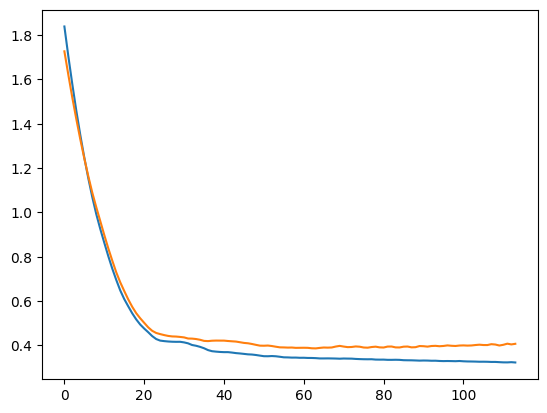

In [ ]:
plt.plot(h_gru_8.history["loss"])
plt.plot(h_gru_8.history["val_loss"])

# 9

In [ ]:
inputs = keras.Input(shape=(X_DATA_TRAIN.shape[1:]))
m = inputs

mA = Dense(units=100, activation='tanh')(m)

m = Flatten()(mA)

# Añadir capa Dense de salida
out = Dense(Y_DATA_TRAIN.shape[1], activation='tanh')(m)

model_GRU_9 = keras.Model(inputs=inputs, outputs=out)

# Compilar el modelo
model_GRU_9.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse',
        metrics=[])

model_GRU_9.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 35, 8)]           0         
                                                                 
 dense_11 (Dense)            (None, 35, 100)           900       
                                                                 
 flatten_8 (Flatten)         (None, 3500)              0         
                                                                 
 dense_12 (Dense)            (None, 35)                122535    
                                                                 
Total params: 123,435
Trainable params: 123,435
Non-trainable params: 0
_________________________________________________________________


# ---- VER PREDICCIONES ---- > > >

# 8

## vemos una prediccion

In [ ]:
x_eje = X_DATA_TEST_OK[35:36]
y_eje = Y_DATA_TEST_OK[35:36]

In [ ]:
y_pred = model_GRU_8(x_eje)
y_pred

<tf.Tensor: shape=(1, 35), dtype=float32, numpy=
array([[ 0.30467546,  0.00934902,  0.0318145 , -0.10692504, -0.168754  ,
         0.12327385,  0.0534845 ,  0.05469586, -0.23827766, -0.07155599,
        -0.11246741, -0.10270008,  0.01281512, -0.20399679,  0.03016939,
         0.0354912 , -0.15591517,  0.11243656,  0.05209925, -0.04551917,
         0.05457422,  0.11521752, -0.02438232,  0.00159059, -0.05852231,
        -0.14591996,  0.15926868, -0.1391583 ,  0.22985   ,  0.15637974,
        -0.09190354, -0.19819763,  0.12627198,  0.06848525,  0.03834023]],
      dtype=float32)>

In [ ]:
y_pred[0].numpy().round(3)

array([ 0.305,  0.009,  0.032, -0.107, -0.169,  0.123,  0.053,  0.055,
       -0.238, -0.072, -0.112, -0.103,  0.013, -0.204,  0.03 ,  0.035,
       -0.156,  0.112,  0.052, -0.046,  0.055,  0.115, -0.024,  0.002,
       -0.059, -0.146,  0.159, -0.139,  0.23 ,  0.156, -0.092, -0.198,
        0.126,  0.068,  0.038], dtype=float32)

In [ ]:
ranking_pred = np.argsort(np.argsort(-y_pred))
ranking_pred

array([[ 0, 18, 15, 26, 31,  5, 11,  9, 34, 23, 27, 25, 17, 33, 16, 14,
        30,  7, 12, 21, 10,  6, 20, 19, 22, 29,  2, 28,  1,  3, 24, 32,
         4,  8, 13]])

In [ ]:
y_eje

array([[-0.23529412,  0.58823529,  1.        , -0.70588235, -0.76470588,
         0.05882353,  0.82352941,  0.70588235, -0.88235294, -0.17647059,
        -0.11764706,  0.64705882,  0.17647059, -0.94117647,  0.47058824,
        -0.29411765, -0.58823529,  0.35294118, -0.82352941, -1.        ,
         0.94117647,  0.52941176, -0.35294118,  0.29411765, -0.47058824,
        -0.64705882,  0.41176471, -0.52941176,  0.88235294,  0.76470588,
         0.        , -0.41176471,  0.11764706,  0.23529412, -0.05882353]])

In [ ]:
ranking = np.argsort(np.argsort(-y_eje))
ranking

array([[21,  7,  0, 29, 30, 16,  3,  5, 32, 20, 19,  6, 14, 33,  9, 22,
        27, 11, 31, 34,  1,  8, 23, 12, 25, 28, 10, 26,  2,  4, 17, 24,
        15, 13, 18]])

In [ ]:
ranking - ranking_pred

array([[ 21, -11, -15,   3,  -1,  11,  -8,  -4,  -2,  -3,  -8, -19,  -3,
          0,  -7,   8,  -3,   4,  19,  13,  -9,   2,   3,  -7,   3,  -1,
          8,  -2,   1,   1,  -7,  -8,  11,   5,   5]])

In [ ]:
np.where(ranking_pred < 10)[1]

array([ 0,  5,  7, 17, 21, 26, 28, 29, 32, 33])

In [ ]:
np.where(ranking < 10)[1]

array([ 1,  2,  6,  7, 11, 14, 20, 21, 28, 29])

cuantos activos del ranking real estan dentro del ranking predicho

In [ ]:
len (
    set(np.where(ranking_pred < 10)[1]) & set(np.where(ranking < 10)[1])
)

4

como de lejos estan los activos del top 10 de su posicion

In [ ]:
puntos_ranking_pred =  ranking_pred[0][np.where(ranking_pred < 10)[1]]
puntos_ranking_pred

array([0, 5, 9, 7, 6, 2, 1, 3, 4, 8])

In [ ]:
puntos_ranking_real = ranking[0][np.where(ranking_pred < 10)[1]]
puntos_ranking_real

array([21, 16,  5, 11,  8, 10,  2,  4, 15, 13])

In [ ]:
abs(puntos_ranking_pred - puntos_ranking_real).mean()

6.8

## ahora con todo el dataset de test

In [ ]:
X_DATA_TEST_OK.shape

(174, 35, 8)

In [ ]:


def ver_comportamiento(MODELO,X_ANALSIS, Y_ANALISIS  ):
  top_activos = 10

  t_activos_in_top = []
  t_evaluacion = []
  t_distancia_media_de_top = []

  MODELO = model_GRU_8
  X_ANALSIS = X_DATA_TEST_OK
  Y_ANALISIS = Y_DATA_TEST_OK

  for i in range(X_ANALSIS.shape[0]):
    print(X_ANALSIS[i:i+1].shape)

    y_pred = MODELO(X_ANALSIS[i:i+1])
    ranking_pred = np.argsort(np.argsort(-y_pred))

    ranking = np.argsort(np.argsort(-Y_ANALISIS[i:i+1]))

    # cuantos activos del ranking real estan dentro del ranking predicho

    activos_in_top = len ( set(np.where(ranking_pred < top_activos)[1]) & set(np.where(ranking < top_activos)[1]) )

    evaluacion = MODELO.evaluate(X_ANALSIS[i:i+1], Y_ANALISIS[i:i+1] )

    # como de lejos estan los activos del top 10 de su posicion

    puntos_ranking_pred =  ranking_pred[0][np.where(ranking_pred < top_activos)[1]]
    puntos_ranking_real = ranking[0][np.where(ranking_pred < top_activos)[1]]

    puntos = abs(puntos_ranking_pred - puntos_ranking_real).mean()


    t_activos_in_top.append(activos_in_top)
    t_evaluacion.append(evaluacion)
    t_distancia_media_de_top.append(puntos)

  return t_activos_in_top, t_evaluacion, t_distancia_media_de_top


In [ ]:
MODELO = model_GRU_8
X_ANALSIS = X_DATA_TEST_OK
Y_ANALISIS = Y_DATA_TEST_OK

t_activos_in_top, t_evaluacion, t_distancia_media_de_top = ver_comportamiento(MODELO,X_ANALSIS, Y_ANALISIS  )

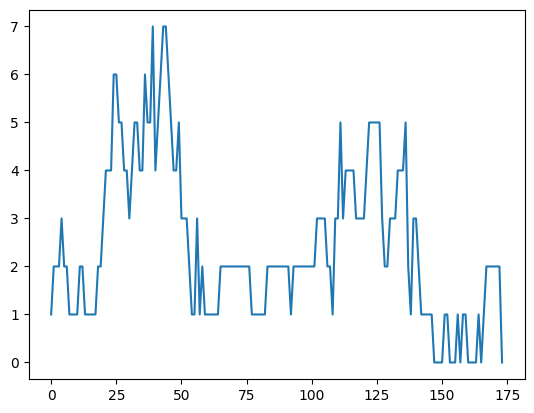

In [ ]:
plt.plot(t_activos_in_top)

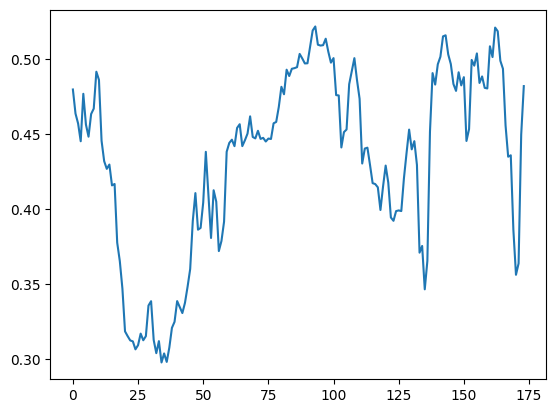

In [ ]:
plt.plot(t_evaluacion)

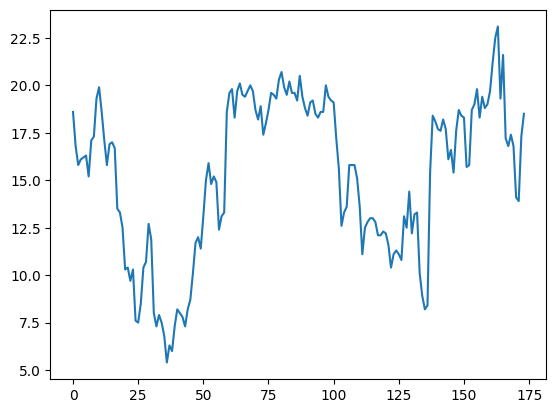

In [ ]:
plt.plot(t_distancia_media_de_top)

In [ ]:
import numpy as np

In [ ]:
# FRAGMENTO DE MODELO EVOLUTIVO
population = np.array([[1,4,3], [1,3,4],[6,3,5],[6,4,3], [1,2,4],[8,3,5]])
fitness = np.array([5,6,5.5,1,9,1.3])


"""
guardar en dos srrays diferentes los 3 mejores individuos ordenados

"""
best_population =
best_fitness =

new_population = np.array([[7,4,3], [1,4,4],[1,3,5],[6,3,3], [1,2,8],[4,3,5]])
new_fitness = np.array([4,2,3.5,4,2,2])

"""
ver que nuevos indidividuos en base a su fitness son mejores que lo anteriores mejores y guardar los nuevos best
"""

best_population =
best_fitness =




SyntaxError: ignored

In [ ]:
import numpy as np

population = np.array([[1,4,3], [2,3,4],[3,3,5],[4,4,3], [5,2,4],[6,3,5]])
fitness = np.array([1,2,3,4,5,6])

# Guardar en dos arrays diferentes los 3 mejores individuos ordenados
sorted_indices = np.argsort(fitness)[:3]  # Ordenamos de menor a mayor
#print(sorted_indices)
best_population = population[sorted_indices]
print(best_population)
best_fitness = fitness[sorted_indices]
print(best_fitness)
print("------")
new_population = np.array([[1,5,3], [2,4,4],[3,3,5],[4,3,3], [5,2,8],[6,3,5]])
new_fitness = np.array([1,8,9,5,6,7])

# Ver qué nuevos individuos en base a su fitness son mejores que los anteriores mejores
combined_population = np.vstack([best_population, new_population])
combined_fitness = np.concatenate([best_fitness, new_fitness])

sorted_indices = np.argsort(combined_fitness)[:3]  # Ordenamos de menor a mayor
best_population = combined_population[sorted_indices]
best_fitness = combined_fitness[sorted_indices]

print(best_population)
print(best_fitness)